In [1]:
# get the environment
import sys
print(sys.version)
print(sys.executable)

3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
C:\Users\bbutler\Documents\Anaconda3\envs\timeseries\python.exe


In [2]:
# import base libraries
from IPython.core.display import display, HTML
from dateutil import relativedelta
import pandas as pd
import numpy as np
import pyodbc
import os
import re
import statistics as stat
import datetime as dt
from datetime import timedelta

# additional imports for visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# for expanding plots
from pylab import rcParams

# for formatting plots
import matplotlib as mpl


%matplotlib inline

# set options
display(HTML("<style>.container {width:90% !important;} </style>"))
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
pd.__version__

'1.0.5'

In [4]:
def AP2_QUERY(sql):
    con = pyodbc.connect('DSN=AP2')
    cursor = con.cursor()
    c = cursor.execute(sql)
    dff = pd.DataFrame.from_records(c.fetchall(),columns=[x[0] for x in c.description])
    return dff
    cursor.close()
    con.close() 


In [5]:
accts = AP2_QUERY('''
SELECT CAST([AppEntryCompletedDate] as date) as [AppDate],
[Textbox26] as [CustName],
[CustomerNumber],
[appid],
[product],
[testfield] as [AcctNum],
[contractAmt]
FROM [Insights].[CRIF].[Eastern_ConsumerLoanApps]
WHERE BookedYN = 'Yes'
AND product in ('Flex Equity Line of Credit', 'FLEX FIXED DRAW')
AND CAST([AppEntryCompletedDate] as date) > '2019-03-02'
ORDER BY AppDate
''')

accts

,AppDate,CustName,CustomerNumber,appid,product,AcctNum,contractAmt
0,2019-03-04,KEITH WEINSTEIN,00001901765,30233,Flex Equity Line of Credit,3750010874,200000.00
1,2019-03-04,SCOTT MILES,00001402610,30235,Flex Equity Line of Credit,3750010735,30400.00
2,2019-03-04,STEVEN STEIN,00000753014,30212,Flex Equity Line of Credit,3750011504,500000.00
3,2019-03-04,LUCAS RICKER,00002361762,30216,Flex Equity Line of Credit,3750011009,140000.00
4,2019-03-04,ROBERT SYLVA,00001534966,30248,Flex Equity Line of Credit,3750012097,50000.00
...,...,...,...,...,...,...,...
3438,2020-08-14,Donald Burlingame,2003442,58596,Flex Equity Line of Credit,3750022269,100000.00
3439,2020-08-14,LUIGI ROMANO,00000124983,58601,Flex Equity Line of Credit,3750022198,60000.00
3440,2020-08-17,JAMES DELANO,00001558236,58697,Flex Equity Line of Credit,3750022214,25000.00
3441,2020-08-18,DELETA WILLIAMS,00002264790,58771,Flex Equity Line of Credit,3750022250,50000.00


In [6]:
accts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3443 entries, 0 to 3442
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AppDate         3443 non-null   object
 1   CustName        3443 non-null   object
 2   CustomerNumber  3443 non-null   object
 3   appid           3443 non-null   object
 4   product         3443 non-null   object
 5   AcctNum         3443 non-null   object
 6   contractAmt     3443 non-null   object
dtypes: object(7)
memory usage: 188.4+ KB


In [7]:
loans = AP2_QUERY('''
SELECT LN.[Month_End_Date],
LN.[Note_Account_Number],
LN.[Loan_Account_Number],
CAST(LN.[Loan_Account_Number] as bigint) as [Loan_Num],
LN.[Note_Number],
LN.[Year_Month_Number],
LN.[Note_Type_Code],
LN.[Note_Type_Descr],
LN.[Note_Branch_Number],
LN.[Issue_Date],
LN.[Maturity_Date],
LN.[Account_Number_CNT],
LN.[SUM_Ledger_Balance_Amount],
LN.[SUM_Original_Balance]
FROM [EB_Data_Platform].[UnRestricted].[cv_Bank_Loan_Note_Info_Monthly] LN
WHERE [Note_Type_Descr] in ('FLEX EQUITY LINE', 'FLEX FIXED DRAW') 
AND [Issue_Date] > '2019-03-04' 
AND [Month_End_Date] > '2019-03-03' 
ORDER BY Loan_Account_Number, Month_End_Date ASC
''')

loans

,Month_End_Date,Note_Account_Number,Loan_Account_Number,Loan_Num,Note_Number,Year_Month_Number,Note_Type_Code,Note_Type_Descr,Note_Branch_Number,Issue_Date,Maturity_Date,Account_Number_CNT,SUM_Ledger_Balance_Amount,SUM_Original_Balance
0,2020-02-28,00350272332-00004,00350272332,350272332,4,202002,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,121470.76,121470.76
1,2020-03-31,00350272332-00004,00350272332,350272332,4,202003,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,121014.52,121470.76
2,2020-04-30,00350272332-00004,00350272332,350272332,4,202004,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,0.00,121470.76
3,2020-05-29,00350272332-00004,00350272332,350272332,4,202005,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,0.00,121470.76
4,2020-05-29,00350272332-00005,00350272332,350272332,5,202005,390,FLEX FIXED DRAW,315,2020-04-09,2035-02-10,1,119902.83,121485.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39405,2020-08-31,03750021997-00001,03750021997,3750021997,1,202008,190,FLEX EQUITY LINE,372,2020-08-25,0001-01-01,1,0.00,0.00
39406,2020-08-31,03750022005-00001,03750022005,3750022005,1,202008,190,FLEX EQUITY LINE,127,2020-08-25,0001-01-01,1,25000.00,0.00
39407,2020-08-31,03750022022-00001,03750022022,3750022022,1,202008,190,FLEX EQUITY LINE,335,2020-08-25,0001-01-01,1,0.00,0.00
39408,2020-08-31,03750022036-00001,03750022036,3750022036,1,202008,190,FLEX EQUITY LINE,335,2020-08-25,0001-01-01,1,0.00,0.00


In [8]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39410 entries, 0 to 39409
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Month_End_Date             39410 non-null  datetime64[ns]
 1   Note_Account_Number        39410 non-null  object        
 2   Loan_Account_Number        39410 non-null  object        
 3   Loan_Num                   39410 non-null  int64         
 4   Note_Number                39410 non-null  int64         
 5   Year_Month_Number          39410 non-null  object        
 6   Note_Type_Code             39410 non-null  object        
 7   Note_Type_Descr            39410 non-null  object        
 8   Note_Branch_Number         39410 non-null  int64         
 9   Issue_Date                 39410 non-null  object        
 10  Maturity_Date              39410 non-null  object        
 11  Account_Number_CNT         39410 non-null  int64         
 12  SUM_

In [9]:
 # make dates
    
accts['AppDate'] = pd.to_datetime(accts['AppDate'], format='%Y-%m-%d')

loans['Issue_Date'] = pd.to_datetime(loans['Issue_Date'], format='%Y-%m-%d')

In [10]:
# strip whitespace
# data['values'].str.strip()

accts['CustomerNumber'] = accts['CustomerNumber'].str.strip()

In [11]:
# check for isdigit

accts['Digit'] = accts['CustomerNumber'].str.isdigit()
accts.head()

,AppDate,CustName,CustomerNumber,appid,product,AcctNum,contractAmt,Digit
0,2019-03-04,KEITH WEINSTEIN,00001901765,30233,Flex Equity Line of Credit,3750010874,200000.00,True
1,2019-03-04,SCOTT MILES,00001402610,30235,Flex Equity Line of Credit,3750010735,30400.00,True
2,2019-03-04,STEVEN STEIN,00000753014,30212,Flex Equity Line of Credit,3750011504,500000.00,True
3,2019-03-04,LUCAS RICKER,00002361762,30216,Flex Equity Line of Credit,3750011009,140000.00,True
4,2019-03-04,ROBERT SYLVA,00001534966,30248,Flex Equity Line of Credit,3750012097,50000.00,True


In [12]:
accts['Digit'].value_counts()

True     3440
False       3
Name: Digit, dtype: int64

In [13]:
# look at the problems

nonDig = accts[accts['Digit'] == False]
nonDig

,AppDate,CustName,CustomerNumber,appid,product,AcctNum,contractAmt,Digit
1033,2019-05-21,MARK WESTON,,35794,Flex Equity Line of Credit,3750013311,110000.00,False
1556,2019-08-10,RICHARD CONNORS,,40613,Flex Equity Line of Credit,3750015862,70000.00,False
3394,2020-07-30,GREGORY DUNDORF,,57929,Flex Equity Line of Credit,3750022208,200000.00,False


In [14]:
nonDig['CustomerNumber']

1033    
1556    
3394    
Name: CustomerNumber, dtype: object

In [15]:
# drop blanks
# df.drop(df[df.score < 50].index, inplace=True)

accts.drop(accts[accts['Digit'] == False].index, inplace=True)
accts['Digit'].value_counts()

True    3440
Name: Digit, dtype: int64

In [16]:
# make values as numeric for accts CustomerNumber, AcctNum, contractAmt

accts['CustomerNumber'] = accts['CustomerNumber'].astype(int)

accts['AcctNum'] = accts['AcctNum'].astype(np.int64)

accts['contractAmt'] = accts['contractAmt'].astype(float)

In [17]:
# convert Loan values to numeric: Loan_Account_Number, SUM_Ledger_Balance_Amount, SUM_Original_Balance
loans['Loan_Account_Number'] = loans['Loan_Account_Number'].astype(np.int64)

loans['SUM_Ledger_Balance_Amount'] = loans['SUM_Ledger_Balance_Amount'].astype(float)

loans['SUM_Original_Balance'] = loans['SUM_Original_Balance'].astype(float)


In [18]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39410 entries, 0 to 39409
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Month_End_Date             39410 non-null  datetime64[ns]
 1   Note_Account_Number        39410 non-null  object        
 2   Loan_Account_Number        39410 non-null  int64         
 3   Loan_Num                   39410 non-null  int64         
 4   Note_Number                39410 non-null  int64         
 5   Year_Month_Number          39410 non-null  object        
 6   Note_Type_Code             39410 non-null  object        
 7   Note_Type_Descr            39410 non-null  object        
 8   Note_Branch_Number         39410 non-null  int64         
 9   Issue_Date                 39410 non-null  datetime64[ns]
 10  Maturity_Date              39410 non-null  object        
 11  Account_Number_CNT         39410 non-null  int64         
 12  SUM_

In [19]:
loans.head()

,Month_End_Date,Note_Account_Number,Loan_Account_Number,Loan_Num,Note_Number,Year_Month_Number,Note_Type_Code,Note_Type_Descr,Note_Branch_Number,Issue_Date,Maturity_Date,Account_Number_CNT,SUM_Ledger_Balance_Amount,SUM_Original_Balance
0,2020-02-28,00350272332-00004,350272332,350272332,4,202002,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,121470.76,121470.76
1,2020-03-31,00350272332-00004,350272332,350272332,4,202003,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,121014.52,121470.76
2,2020-04-30,00350272332-00004,350272332,350272332,4,202004,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,0.00,121470.76
3,2020-05-29,00350272332-00004,350272332,350272332,4,202005,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,0.00,121470.76
4,2020-05-29,00350272332-00005,350272332,350272332,5,202005,390,FLEX FIXED DRAW,315,2020-04-09,2035-02-10,1,119902.83,121485.69


In [20]:
loans['Loan_Num'].isna().sum()

0

In [21]:
accts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3440 entries, 0 to 3442
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   AppDate         3440 non-null   datetime64[ns]
 1   CustName        3440 non-null   object        
 2   CustomerNumber  3440 non-null   int32         
 3   appid           3440 non-null   object        
 4   product         3440 non-null   object        
 5   AcctNum         3440 non-null   int64         
 6   contractAmt     3440 non-null   float64       
 7   Digit           3440 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 204.9+ KB


In [22]:
# check unique acctnum

len(accts['AcctNum'].unique())

3440

In [23]:
accts.head()

,AppDate,CustName,CustomerNumber,appid,product,AcctNum,contractAmt,Digit
0,2019-03-04,KEITH WEINSTEIN,1901765,30233,Flex Equity Line of Credit,3750010874,200000.00,True
1,2019-03-04,SCOTT MILES,1402610,30235,Flex Equity Line of Credit,3750010735,30400.00,True
2,2019-03-04,STEVEN STEIN,753014,30212,Flex Equity Line of Credit,3750011504,500000.00,True
3,2019-03-04,LUCAS RICKER,2361762,30216,Flex Equity Line of Credit,3750011009,140000.00,True
4,2019-03-04,ROBERT SYLVA,1534966,30248,Flex Equity Line of Credit,3750012097,50000.00,True


In [24]:
# change Customer Number to Object
accts['CustomerNumber'] = accts['CustomerNumber'].astype('object')

In [25]:
# clean the join fields to object
loans['Loan_Num'] = loans['Loan_Num'].astype('object')
accts['AcctNum'] = accts['AcctNum'].astype('object')

In [26]:
# check how many distinct numbers there are
loanSet = set(loans['Loan_Num'])

print(len(loanSet))

acctsSet = set(accts['AcctNum'])
print(len(acctsSet))


3589
3440


In [27]:
# how many match

len(acctsSet.intersection(loanSet))

3346

In [28]:
# miss rate
(3440 - 3346)/3589

0.02619113959320145

In [29]:
# left join
# cross_sale_merged = pd.merge(cross_sale_base,cross_sales_filt,left_on=["CIS_BASE"],right_on=["CIS"],how='inner')

helocLoans = pd.merge(loans, accts, left_on=['Loan_Num'], right_on=['AcctNum'], how = 'left')
helocLoans.head(10)

,Month_End_Date,Note_Account_Number,Loan_Account_Number,Loan_Num,Note_Number,Year_Month_Number,Note_Type_Code,Note_Type_Descr,Note_Branch_Number,Issue_Date,Maturity_Date,Account_Number_CNT,SUM_Ledger_Balance_Amount,SUM_Original_Balance,AppDate,CustName,CustomerNumber,appid,product,AcctNum,contractAmt,Digit
0,2020-02-28,00350272332-00004,350272332,350272332,4,202002,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,121470.76,121470.76,NaT,NaN,NaN,NaN,NaN,NaN,nan,NaN
1,2020-03-31,00350272332-00004,350272332,350272332,4,202003,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,121014.52,121470.76,NaT,NaN,NaN,NaN,NaN,NaN,nan,NaN
2,2020-04-30,00350272332-00004,350272332,350272332,4,202004,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,0.00,121470.76,NaT,NaN,NaN,NaN,NaN,NaN,nan,NaN
3,2020-05-29,00350272332-00004,350272332,350272332,4,202005,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,0.00,121470.76,NaT,NaN,NaN,NaN,NaN,NaN,nan,NaN
4,2020-05-29,00350272332-00005,350272332,350272332,5,202005,390,FLEX FIXED DRAW,315,2020-04-09,2035-02-10,1,119902.83,121485.69,NaT,NaN,NaN,NaN,NaN,NaN,nan,NaN
5,2020-06-30,00350272332-00005,350272332,350272332,5,202006,390,FLEX FIXED DRAW,315,2020-04-09,2035-02-10,1,119423.31,121485.69,NaT,NaN,NaN,NaN,NaN,NaN,nan,NaN
6,2020-06-30,00350272332-00004,350272332,350272332,4,202006,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,0.00,121470.76,NaT,NaN,NaN,NaN,NaN,NaN,nan,NaN
7,2020-07-31,00350272332-00005,350272332,350272332,5,202007,390,FLEX FIXED DRAW,315,2020-04-09,2035-02-10,1,118927.02,121485.69,NaT,NaN,NaN,NaN,NaN,NaN,nan,NaN
8,2020-07-31,00350272332-00004,350272332,350272332,4,202007,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,0.00,121470.76,NaT,NaN,NaN,NaN,NaN,NaN,nan,NaN
9,2020-08-31,00350272332-00004,350272332,350272332,4,202008,390,FLEX FIXED DRAW,315,2020-02-08,2035-02-10,1,0.00,121470.76,NaT,NaN,NaN,NaN,NaN,NaN,nan,NaN


In [30]:
# missing

helocLoans['CustomerNumber'].isna().sum()

3560

In [31]:
# total

len(helocLoans)

39410

In [32]:
helocLoans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39410 entries, 0 to 39409
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Month_End_Date             39410 non-null  datetime64[ns]
 1   Note_Account_Number        39410 non-null  object        
 2   Loan_Account_Number        39410 non-null  int64         
 3   Loan_Num                   39410 non-null  object        
 4   Note_Number                39410 non-null  int64         
 5   Year_Month_Number          39410 non-null  object        
 6   Note_Type_Code             39410 non-null  object        
 7   Note_Type_Descr            39410 non-null  object        
 8   Note_Branch_Number         39410 non-null  int64         
 9   Issue_Date                 39410 non-null  datetime64[ns]
 10  Maturity_Date              39410 non-null  object        
 11  Account_Number_CNT         39410 non-null  int64         
 12  SUM_

In [ ]:
helocLoans.dropna(subset=['AcctNum']).info()

In [33]:
# remove the NA's

helocData = helocLoans.dropna(subset=['AcctNum'])
helocData.head()

,Month_End_Date,Note_Account_Number,Loan_Account_Number,Loan_Num,Note_Number,Year_Month_Number,Note_Type_Code,Note_Type_Descr,Note_Branch_Number,Issue_Date,Maturity_Date,Account_Number_CNT,SUM_Ledger_Balance_Amount,SUM_Original_Balance,AppDate,CustName,CustomerNumber,appid,product,AcctNum,contractAmt,Digit
2599,2019-03-29,03750010487-00001,3750010487,3750010487,1,201903,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,54173.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000.00,True
2600,2019-04-30,03750010487-00001,3750010487,3750010487,1,201904,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,52973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000.00,True
2601,2019-05-31,03750010487-00001,3750010487,3750010487,1,201905,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,51973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000.00,True
2602,2019-06-28,03750010487-00001,3750010487,3750010487,1,201906,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,50973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000.00,True
2603,2019-07-31,03750010487-00001,3750010487,3750010487,1,201907,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,58972.09,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000.00,True


In [34]:
# create utilization

helocData['Utilization'] = helocData['SUM_Ledger_Balance_Amount']/helocData['contractAmt']
helocData.head()

,Month_End_Date,Note_Account_Number,Loan_Account_Number,Loan_Num,Note_Number,Year_Month_Number,Note_Type_Code,Note_Type_Descr,Note_Branch_Number,Issue_Date,Maturity_Date,Account_Number_CNT,SUM_Ledger_Balance_Amount,SUM_Original_Balance,AppDate,CustName,CustomerNumber,appid,product,AcctNum,contractAmt,Digit,Utilization
2599,2019-03-29,03750010487-00001,3750010487,3750010487,1,201903,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,54173.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000.00,True,0.54
2600,2019-04-30,03750010487-00001,3750010487,3750010487,1,201904,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,52973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000.00,True,0.53
2601,2019-05-31,03750010487-00001,3750010487,3750010487,1,201905,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,51973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000.00,True,0.52
2602,2019-06-28,03750010487-00001,3750010487,3750010487,1,201906,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,50973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000.00,True,0.51
2603,2019-07-31,03750010487-00001,3750010487,3750010487,1,201907,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,58972.09,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000.00,True,0.59


In [35]:
os.getcwd()

'C:\\Users\\bbutler\\Documents\\HELOC'

In [36]:
# write to CSV
# cross_sale_merged.to_csv('crossSaleDate.csv')

helocData.to_csv('helocLoanUtilData.csv', index=False )

In [37]:
helocData['Note_Type_Descr'].unique()

array(['FLEX EQUITY LINE', 'FLEX FIXED DRAW'], dtype=object)

In [38]:
helocData['product'].unique()

array(['Flex Equity Line of Credit'], dtype=object)

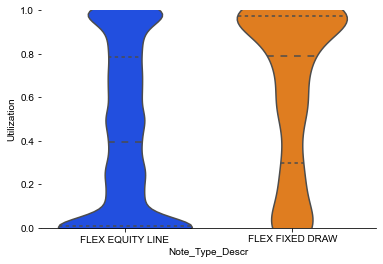

In [39]:
# do a nice violin plot
fig, ax = plt.subplots()
sns.set(style="whitegrid", palette="bright", color_codes=True, rc = {'figure.figsize':(12,8)})


# Draw a nested violinplot and split the violins for easier comparison
p = sns.violinplot(x="Note_Type_Descr", y="Utilization",
               split=True, inner="quart",
               #palette={"Active": "b", "Inactive": "y"},
               data=helocData)
p.set(ylim=(0, 1))

sns.despine(left=True)

In [40]:
helocData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35850 entries, 2599 to 39409
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Month_End_Date             35850 non-null  datetime64[ns]
 1   Note_Account_Number        35850 non-null  object        
 2   Loan_Account_Number        35850 non-null  int64         
 3   Loan_Num                   35850 non-null  object        
 4   Note_Number                35850 non-null  int64         
 5   Year_Month_Number          35850 non-null  object        
 6   Note_Type_Code             35850 non-null  object        
 7   Note_Type_Descr            35850 non-null  object        
 8   Note_Branch_Number         35850 non-null  int64         
 9   Issue_Date                 35850 non-null  datetime64[ns]
 10  Maturity_Date              35850 non-null  object        
 11  Account_Number_CNT         35850 non-null  int64         
 12  S

In [41]:
helocData['contractAmt'] = helocData['contractAmt'].astype('int')

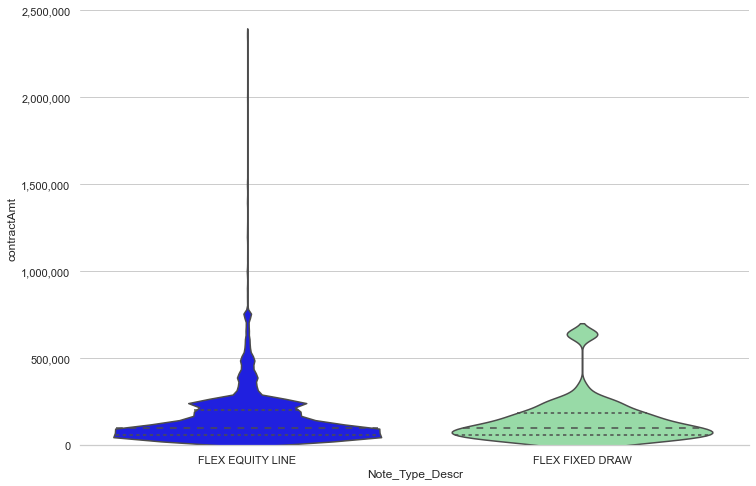

In [42]:
# do a nice violin plot
fig, ax = plt.subplots()
sns.set(style="whitegrid", palette="pastel", color_codes=True, rc = {'figure.figsize':(12,10)})


# Draw a nested violinplot and split the violins for easier comparison

p = sns.violinplot(x="Note_Type_Descr", y="contractAmt",
               split=True, inner="quart",
               palette={'FLEX EQUITY LINE': 'blue', 'FLEX FIXED DRAW': 'g'},
               data=helocData)
p.set(ylim=(0, 2500000))
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

sns.despine(left=True)

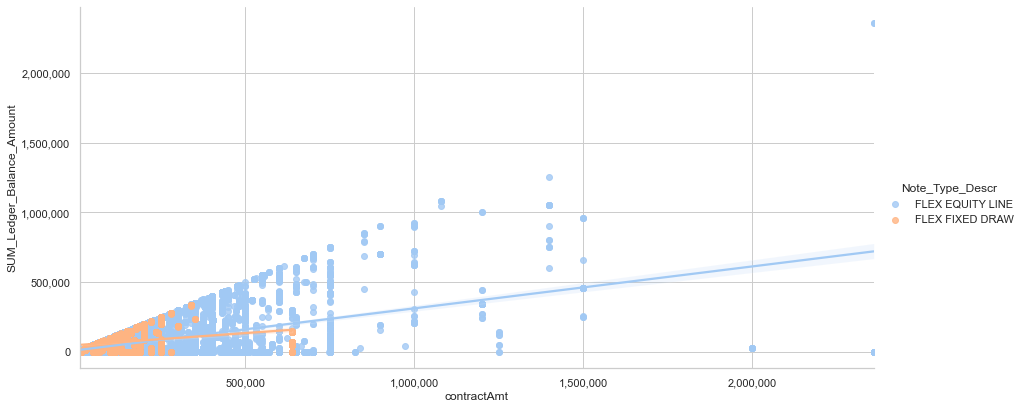

In [43]:
p = sns.lmplot(x="contractAmt", y="SUM_Ledger_Balance_Amount", data=helocData, height = 6, aspect = 2, hue = 'Note_Type_Descr')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

for ax in p.axes[:,0]:
# ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [44]:
# ensure data is sorted

helocData = helocData.sort_values(['Loan_Num', 'Month_End_Date'],ascending=[True, True])
helocData.head(20)

,Month_End_Date,Note_Account_Number,Loan_Account_Number,Loan_Num,Note_Number,Year_Month_Number,Note_Type_Code,Note_Type_Descr,Note_Branch_Number,Issue_Date,Maturity_Date,Account_Number_CNT,SUM_Ledger_Balance_Amount,SUM_Original_Balance,AppDate,CustName,CustomerNumber,appid,product,AcctNum,contractAmt,Digit,Utilization
2599,2019-03-29,03750010487-00001,3750010487,3750010487,1,201903,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,54173.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.54
2600,2019-04-30,03750010487-00001,3750010487,3750010487,1,201904,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,52973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.53
2601,2019-05-31,03750010487-00001,3750010487,3750010487,1,201905,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,51973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.52
2602,2019-06-28,03750010487-00001,3750010487,3750010487,1,201906,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,50973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.51
2603,2019-07-31,03750010487-00001,3750010487,3750010487,1,201907,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,58972.09,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.59
2604,2019-08-30,03750010487-00001,3750010487,3750010487,1,201908,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,53972.09,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.54
2605,2019-09-30,03750010487-00001,3750010487,3750010487,1,201909,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,52764.96,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.53
2606,2019-10-31,03750010487-00001,3750010487,3750010487,1,201910,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,51477.72,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.51
2607,2019-11-29,03750010487-00001,3750010487,3750010487,1,201911,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,50664.96,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.51
2608,2019-12-31,03750010487-00001,3750010487,3750010487,1,201912,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,49464.96,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.49


In [45]:
# shift the AcctNum to create month count

helocData['Count'] = helocData['AcctNum'].eq(helocData['AcctNum'].shift())
helocData.head(40)

,Month_End_Date,Note_Account_Number,Loan_Account_Number,Loan_Num,Note_Number,Year_Month_Number,Note_Type_Code,Note_Type_Descr,Note_Branch_Number,Issue_Date,Maturity_Date,Account_Number_CNT,SUM_Ledger_Balance_Amount,SUM_Original_Balance,AppDate,CustName,CustomerNumber,appid,product,AcctNum,contractAmt,Digit,Utilization,Count
2599,2019-03-29,03750010487-00001,3750010487,3750010487,1,201903,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,54173.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.54,False
2600,2019-04-30,03750010487-00001,3750010487,3750010487,1,201904,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,52973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.53,True
2601,2019-05-31,03750010487-00001,3750010487,3750010487,1,201905,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,51973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.52,True
2602,2019-06-28,03750010487-00001,3750010487,3750010487,1,201906,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,50973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.51,True
2603,2019-07-31,03750010487-00001,3750010487,3750010487,1,201907,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,58972.09,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.59,True
2604,2019-08-30,03750010487-00001,3750010487,3750010487,1,201908,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,53972.09,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.54,True
2605,2019-09-30,03750010487-00001,3750010487,3750010487,1,201909,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,52764.96,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.53,True
2606,2019-10-31,03750010487-00001,3750010487,3750010487,1,201910,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,51477.72,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.51,True
2607,2019-11-29,03750010487-00001,3750010487,3750010487,1,201911,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,50664.96,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.51,True
2608,2019-12-31,03750010487-00001,3750010487,3750010487,1,201912,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,49464.96,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.49,True


In [ ]:
df.loc[df['X'] == 1, 'Y'].sum()
helocData = helocData.drop('Count', axis = 1)
helocData.head()

In [ ]:
# df['Cumulative'] = df.groupby('TransactionId')['Delta'].cumsum()
# useful but not needed

helocData['MonthOut'] = helocData.groupby('AcctNum')['MonthCount'].cumsum()
helocData.head(50)

In [47]:
# just do date diff from origination
# # calculate the days since last login
#allData['DaysSinceLogin'] = allData['RefDate'] - allData['LastLoginDateClean']

# convert to clean days using hours
#allData['DaysSinceLogin'] = (allData['DaysSinceLogin'].astype('timedelta64[D]'))

helocData['daysFromOpen'] = (helocData['Month_End_Date'] - helocData['Issue_Date']).astype('timedelta64[D]')

helocData.head(20)


,Month_End_Date,Note_Account_Number,Loan_Account_Number,Loan_Num,Note_Number,Year_Month_Number,Note_Type_Code,Note_Type_Descr,Note_Branch_Number,Issue_Date,Maturity_Date,Account_Number_CNT,SUM_Ledger_Balance_Amount,SUM_Original_Balance,AppDate,CustName,CustomerNumber,appid,product,AcctNum,contractAmt,Digit,Utilization,Count,daysFromOpen
2599,2019-03-29,03750010487-00001,3750010487,3750010487,1,201903,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,54173.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.54,False,10.00
2600,2019-04-30,03750010487-00001,3750010487,3750010487,1,201904,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,52973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.53,True,42.00
2601,2019-05-31,03750010487-00001,3750010487,3750010487,1,201905,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,51973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.52,True,73.00
2602,2019-06-28,03750010487-00001,3750010487,3750010487,1,201906,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,50973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.51,True,101.00
2603,2019-07-31,03750010487-00001,3750010487,3750010487,1,201907,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,58972.09,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.59,True,134.00
2604,2019-08-30,03750010487-00001,3750010487,3750010487,1,201908,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,53972.09,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.54,True,164.00
2605,2019-09-30,03750010487-00001,3750010487,3750010487,1,201909,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,52764.96,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.53,True,195.00
2606,2019-10-31,03750010487-00001,3750010487,3750010487,1,201910,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,51477.72,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.51,True,226.00
2607,2019-11-29,03750010487-00001,3750010487,3750010487,1,201911,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,50664.96,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.51,True,255.00
2608,2019-12-31,03750010487-00001,3750010487,3750010487,1,201912,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,49464.96,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.49,True,287.00


In [48]:
helocData['Issue_Date'].min()

Timestamp('2019-03-14 00:00:00')

In [49]:
helocData['Issue_Date'].max()

Timestamp('2020-08-26 00:00:00')

In [50]:
helocData['daysFromOpen'].max()

536.0

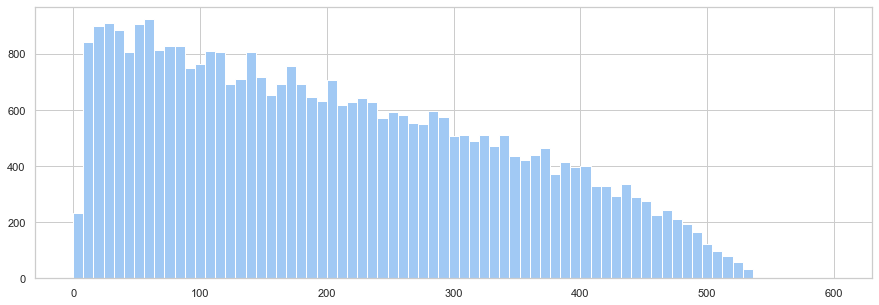

In [51]:
helocData['daysFromOpen'].hist(bins=75, range = [0,600], align = 'mid', figsize=(15,5))

In [90]:
# bin the data
# test['range1'] = pd.cut(test.days, [0,30,60], include_lowest=True)
labels = ['Month1', 'Month2', 'Month3', 'Month4', 'Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10', 'Month11', '1Yr', '1Yr+']

helocData['UtilMonth'] = pd.cut(helocData['daysFromOpen'], [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 1000],
                                include_lowest=True, labels = labels)

helocData.head()

,Month_End_Date,Note_Account_Number,Loan_Account_Number,Loan_Num,Note_Number,Year_Month_Number,Note_Type_Code,Note_Type_Descr,Note_Branch_Number,Issue_Date,Maturity_Date,Account_Number_CNT,SUM_Ledger_Balance_Amount,SUM_Original_Balance,AppDate,CustName,CustomerNumber,appid,product,AcctNum,contractAmt,Digit,Utilization,Count,daysFromOpen,utilMonth,UtilMonth,OrigUtil
2599,2019-03-29,03750010487-00001,3750010487,3750010487,1,201903,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,54173.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.54,False,10.00,Month1,Month1,0.00
2600,2019-04-30,03750010487-00001,3750010487,3750010487,1,201904,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,52973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.53,True,42.00,Month2,Month2,0.00
2601,2019-05-31,03750010487-00001,3750010487,3750010487,1,201905,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,51973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.52,True,73.00,Month3,Month3,0.00
2602,2019-06-28,03750010487-00001,3750010487,3750010487,1,201906,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,50973.05,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.51,True,101.00,Month4,Month4,0.00
2603,2019-07-31,03750010487-00001,3750010487,3750010487,1,201907,190,FLEX EQUITY LINE,308,2019-03-19,0001-01-01,1,58972.09,0.00,2019-03-04,KAREN ASH,1907356,30234,Flex Equity Line of Credit,3750010487,100000,True,0.59,True,134.00,Month5,Month5,0.00


In [91]:
helocData['OrigUtil'] = helocData['SUM_Original_Balance']/helocData['contractAmt']

In [100]:
helocData[helocData['Note_Account_Number'] == '03750010889-00001']

,Month_End_Date,Note_Account_Number,Loan_Account_Number,Loan_Num,Note_Number,Year_Month_Number,Note_Type_Code,Note_Type_Descr,Note_Branch_Number,Issue_Date,Maturity_Date,Account_Number_CNT,SUM_Ledger_Balance_Amount,SUM_Original_Balance,AppDate,CustName,CustomerNumber,appid,product,AcctNum,contractAmt,Digit,Utilization,Count,daysFromOpen,utilMonth,UtilMonth,OrigUtil
4584,2019-04-30,03750010889-00001,3750010889,3750010889,1,201904,190,FLEX EQUITY LINE,371,2019-03-30,0001-01-01,1,10000.00,0.00,2019-03-11,MINDY TRACY,2054190,30819,Flex Equity Line of Credit,3750010889,200000,True,0.05,False,31.00,Month2,Month2,0.00
4585,2019-05-31,03750010889-00001,3750010889,3750010889,1,201905,190,FLEX EQUITY LINE,371,2019-03-30,0001-01-01,1,10000.00,0.00,2019-03-11,MINDY TRACY,2054190,30819,Flex Equity Line of Credit,3750010889,200000,True,0.05,True,62.00,Month3,Month3,0.00
4586,2019-06-28,03750010889-00001,3750010889,3750010889,1,201906,190,FLEX EQUITY LINE,371,2019-03-30,0001-01-01,1,10000.00,0.00,2019-03-11,MINDY TRACY,2054190,30819,Flex Equity Line of Credit,3750010889,200000,True,0.05,True,90.00,Month3,Month3,0.00
4587,2019-07-31,03750010889-00001,3750010889,3750010889,1,201907,190,FLEX EQUITY LINE,371,2019-03-30,0001-01-01,1,10000.00,0.00,2019-03-11,MINDY TRACY,2054190,30819,Flex Equity Line of Credit,3750010889,200000,True,0.05,True,123.00,Month5,Month5,0.00
4588,2019-08-30,03750010889-00001,3750010889,3750010889,1,201908,190,FLEX EQUITY LINE,371,2019-03-30,0001-01-01,1,7000.00,0.00,2019-03-11,MINDY TRACY,2054190,30819,Flex Equity Line of Credit,3750010889,200000,True,0.04,True,153.00,Month6,Month6,0.00
4589,2019-09-30,03750010889-00001,3750010889,3750010889,1,201909,190,FLEX EQUITY LINE,371,2019-03-30,0001-01-01,1,3027.29,0.00,2019-03-11,MINDY TRACY,2054190,30819,Flex Equity Line of Credit,3750010889,200000,True,0.02,True,184.00,Month7,Month7,0.00
4590,2019-10-31,03750010889-00001,3750010889,3750010889,1,201910,190,FLEX EQUITY LINE,371,2019-03-30,0001-01-01,1,0.00,0.00,2019-03-11,MINDY TRACY,2054190,30819,Flex Equity Line of Credit,3750010889,200000,True,0.00,True,215.00,Month8,Month8,0.00
4591,2019-11-29,03750010889-00001,3750010889,3750010889,1,201911,190,FLEX EQUITY LINE,371,2019-03-30,0001-01-01,1,0.00,0.00,2019-03-11,MINDY TRACY,2054190,30819,Flex Equity Line of Credit,3750010889,200000,True,0.00,True,244.00,Month9,Month9,0.00
4592,2019-12-31,03750010889-00001,3750010889,3750010889,1,201912,190,FLEX EQUITY LINE,371,2019-03-30,0001-01-01,1,0.00,0.00,2019-03-11,MINDY TRACY,2054190,30819,Flex Equity Line of Credit,3750010889,200000,True,0.00,True,276.00,Month10,Month10,0.00
4593,2020-01-31,03750010889-00001,3750010889,3750010889,1,202001,190,FLEX EQUITY LINE,371,2019-03-30,0001-01-01,1,0.00,0.00,2019-03-11,MINDY TRACY,2054190,30819,Flex Equity Line of Credit,3750010889,200000,True,0.00,True,307.00,Month11,Month11,0.00


In [95]:
helocData[helocData['Loan_Num'] == 3750010650]

,Month_End_Date,Note_Account_Number,Loan_Account_Number,Loan_Num,Note_Number,Year_Month_Number,Note_Type_Code,Note_Type_Descr,Note_Branch_Number,Issue_Date,Maturity_Date,Account_Number_CNT,SUM_Ledger_Balance_Amount,SUM_Original_Balance,AppDate,CustName,CustomerNumber,appid,product,AcctNum,contractAmt,Digit,Utilization,Count,daysFromOpen,utilMonth,UtilMonth,OrigUtil
3255,2019-03-29,03750010650-00001,3750010650,3750010650,1,201903,190,FLEX EQUITY LINE,111,2019-03-20,0001-01-01,1,0.00,0.00,2019-03-07,RONDA WINER,855301,30517,Flex Equity Line of Credit,3750010650,61000,True,0.00,False,9.00,Month1,Month1,0.00
3256,2019-03-29,03750010650-00003,3750010650,3750010650,3,201903,390,FLEX FIXED DRAW,111,2019-03-25,2039-03-25,1,61000.00,61000.00,2019-03-07,RONDA WINER,855301,30517,Flex Equity Line of Credit,3750010650,61000,True,1.00,True,4.00,Month1,Month1,1.00
3257,2019-04-30,03750010650-00001,3750010650,3750010650,1,201904,190,FLEX EQUITY LINE,111,2019-03-20,0001-01-01,1,0.00,0.00,2019-03-07,RONDA WINER,855301,30517,Flex Equity Line of Credit,3750010650,61000,True,0.00,True,41.00,Month2,Month2,0.00
3258,2019-04-30,03750010650-00003,3750010650,3750010650,3,201904,390,FLEX FIXED DRAW,111,2019-03-25,2039-03-25,1,60889.62,61000.00,2019-03-07,RONDA WINER,855301,30517,Flex Equity Line of Credit,3750010650,61000,True,1.00,True,36.00,Month2,Month2,1.00
3259,2019-05-31,03750010650-00003,3750010650,3750010650,3,201905,390,FLEX FIXED DRAW,111,2019-03-25,2039-03-25,1,60766.90,61000.00,2019-03-07,RONDA WINER,855301,30517,Flex Equity Line of Credit,3750010650,61000,True,1.00,True,67.00,Month3,Month3,1.00
3260,2019-05-31,03750010650-00001,3750010650,3750010650,1,201905,190,FLEX EQUITY LINE,111,2019-03-20,0001-01-01,1,0.00,0.00,2019-03-07,RONDA WINER,855301,30517,Flex Equity Line of Credit,3750010650,61000,True,0.00,True,72.00,Month3,Month3,0.00
3261,2019-06-28,03750010650-00001,3750010650,3750010650,1,201906,190,FLEX EQUITY LINE,111,2019-03-20,0001-01-01,1,0.00,0.00,2019-03-07,RONDA WINER,855301,30517,Flex Equity Line of Credit,3750010650,61000,True,0.00,True,100.00,Month4,Month4,0.00
3262,2019-06-28,03750010650-00003,3750010650,3750010650,3,201906,390,FLEX FIXED DRAW,111,2019-03-25,2039-03-25,1,60655.13,61000.00,2019-03-07,RONDA WINER,855301,30517,Flex Equity Line of Credit,3750010650,61000,True,0.99,True,95.00,Month4,Month4,1.00
3263,2019-07-31,03750010650-00001,3750010650,3750010650,1,201907,190,FLEX EQUITY LINE,111,2019-03-20,0001-01-01,1,0.00,0.00,2019-03-07,RONDA WINER,855301,30517,Flex Equity Line of Credit,3750010650,61000,True,0.00,True,133.00,Month5,Month5,0.00
3264,2019-07-31,03750010650-00003,3750010650,3750010650,3,201907,390,FLEX FIXED DRAW,111,2019-03-25,2039-03-25,1,60531.07,61000.00,2019-03-07,RONDA WINER,855301,30517,Flex Equity Line of Credit,3750010650,61000,True,0.99,True,128.00,Month5,Month5,1.00


In [106]:
markovData = helocData[['Issue_Date', 'Loan_Account_Number', 'CustomerNumber', 'Note_Type_Descr', 'OrigUtil','Utilization', 'UtilMonth']]
markovData.head()

,Issue_Date,Loan_Account_Number,CustomerNumber,Note_Type_Descr,OrigUtil,Utilization,UtilMonth
2599,2019-03-19,3750010487,1907356,FLEX EQUITY LINE,0.00,0.54,Month1
2600,2019-03-19,3750010487,1907356,FLEX EQUITY LINE,0.00,0.53,Month2
2601,2019-03-19,3750010487,1907356,FLEX EQUITY LINE,0.00,0.52,Month3
2602,2019-03-19,3750010487,1907356,FLEX EQUITY LINE,0.00,0.51,Month4
2603,2019-03-19,3750010487,1907356,FLEX EQUITY LINE,0.00,0.59,Month5


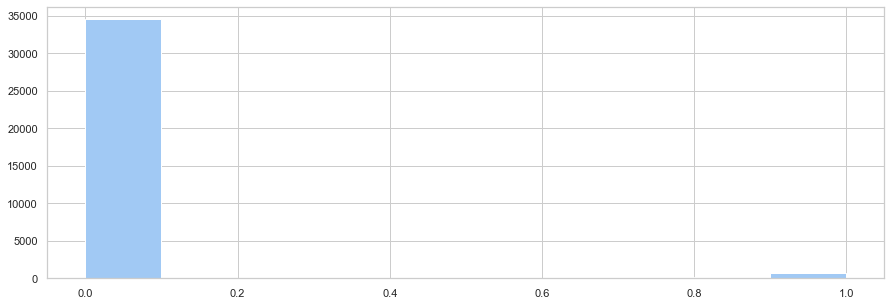

In [93]:
markovData['OrigUtil'].hist(bins=10, range = [0,1], align = 'mid', figsize=(15,5))

In [107]:
# write CSV for use with R

markovData.to_csv('helocMarkovData.csv', index=False )

In [66]:
markovData['UtilMonth'].astype(str)
markovData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35850 entries, 2599 to 39409
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Loan_Account_Number   35850 non-null  int64   
 1   CustomerNumber        35850 non-null  object  
 2   Note_Type_Descr       35850 non-null  object  
 3   SUM_Original_Balance  35850 non-null  float64 
 4   Utilization           35850 non-null  float64 
 5   UtilMonth             35850 non-null  category
dtypes: category(1), float64(2), int64(1), object(2)
memory usage: 1.7+ MB


In [68]:
# pivot the data
# pd.pivot_table(df, values = 'Value', index=['Country','Year'], columns = 'Indicator').reset_index()
# table = df.pivot(index='Country',columns='Year',values='Value')  

# markovTable = pd.pivot_table(markovData, values = 'Utilization', index = ['CustomerNumber', 'Loan_Account_Number'], columns = 'UtilMonth').reset_index()
# markovTable.head()

In [79]:
camp2019 = markovData[markovData['']]

,CustomerNumber,Loan_Account_Number,Utilization,UtilMonth
2599,1907356,3750010487,0.54,Month1
2600,1907356,3750010487,0.53,Month2
2601,1907356,3750010487,0.52,Month3
2602,1907356,3750010487,0.51,Month4
2603,1907356,3750010487,0.59,Month5


In [80]:
months = ['Month1', 'Month2', 'Month3']



markovData3 = markovData2.set_index(['CustomerNumber', 'Loan_Account_Number', 'UtilMonth'])
markovData3.head()

Utilization
CustomerNumber Loan_Account_Number UtilMonth             
1907356        3750010487          Month1            0.54
                                   Month2            0.53
                                   Month3            0.52
                                   Month4            0.51
                                   Month5            0.59